In [42]:
from datasets import load_dataset
from collections import defaultdict
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import torch.nn as nn
import torch.optim as optim
import pandas as pd

device = 'cpu'#'cuda' if torch.cuda.is_available() else 'cpu'

## Clinical Only

In [2]:
class ClinicalSurvivalDataset(Dataset):
    def __init__(self, hf_dataset, survival_days=730):
        self.samples = []
        for item in hf_dataset:
            if item["days_to_death"] is not None:
                embedding = np.frombuffer(item["embedding"], dtype=np.float32)
                embedding = embedding.reshape(item["embedding_shape"])
                label = 1 if int(item["days_to_death"]) >= survival_days else 0
                self.samples.append((embedding, label))

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        embedding, label = self.samples[idx]
        return torch.tensor(embedding, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

In [3]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [15]:
clinical_dataset = load_dataset("Lab-Rasool/TCGA", "clinical", split="gatortron")
dataset = ClinicalSurvivalDataset(clinical_dataset)

# Split into train and val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [16]:
sample_input, _ = next(iter(train_loader))
input_dim =  sample_input.view(sample_input.size(0), -1).shape[1] 

model = MLP(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)

In [17]:
def train(model, loader):
    model.train()
    total_loss = 0
    for x, y in loader:
        optimizer.zero_grad()
        # print(x.shape)
        # print(y.shape)
        output = model(x).squeeze()
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    total_correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            preds = model(x).squeeze() > 0.5
            total_correct += (preds == y.bool()).sum().item()
            total += y.size(0)
    return total_correct / total

In [18]:
train_losses = []
val_accuracies = []
for epoch in range(100):
    train_loss = train(model, train_loader)
    val_acc = evaluate(model, val_loader)
    train_losses.append(train_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1} - Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1 - Loss: 0.6693, Val Acc: 0.6103
Epoch 2 - Loss: 0.6666, Val Acc: 0.6103
Epoch 3 - Loss: 0.6621, Val Acc: 0.6103
Epoch 4 - Loss: 0.6560, Val Acc: 0.6103
Epoch 5 - Loss: 0.6603, Val Acc: 0.6103
Epoch 6 - Loss: 0.6519, Val Acc: 0.6103
Epoch 7 - Loss: 0.6541, Val Acc: 0.6117
Epoch 8 - Loss: 0.6449, Val Acc: 0.6103
Epoch 9 - Loss: 0.6591, Val Acc: 0.6200
Epoch 10 - Loss: 0.6530, Val Acc: 0.6103
Epoch 11 - Loss: 0.6494, Val Acc: 0.6103
Epoch 12 - Loss: 0.6501, Val Acc: 0.6158
Epoch 13 - Loss: 0.6475, Val Acc: 0.6089
Epoch 14 - Loss: 0.6423, Val Acc: 0.6227
Epoch 15 - Loss: 0.6408, Val Acc: 0.6186
Epoch 16 - Loss: 0.6383, Val Acc: 0.6186
Epoch 17 - Loss: 0.6354, Val Acc: 0.6200
Epoch 18 - Loss: 0.6416, Val Acc: 0.6130
Epoch 19 - Loss: 0.6352, Val Acc: 0.6200
Epoch 20 - Loss: 0.6317, Val Acc: 0.6089
Epoch 21 - Loss: 0.6274, Val Acc: 0.5936
Epoch 22 - Loss: 0.6360, Val Acc: 0.6144
Epoch 23 - Loss: 0.6195, Val Acc: 0.6214
Epoch 24 - Loss: 0.6247, Val Acc: 0.5520
Epoch 25 - Loss: 0.6363, 

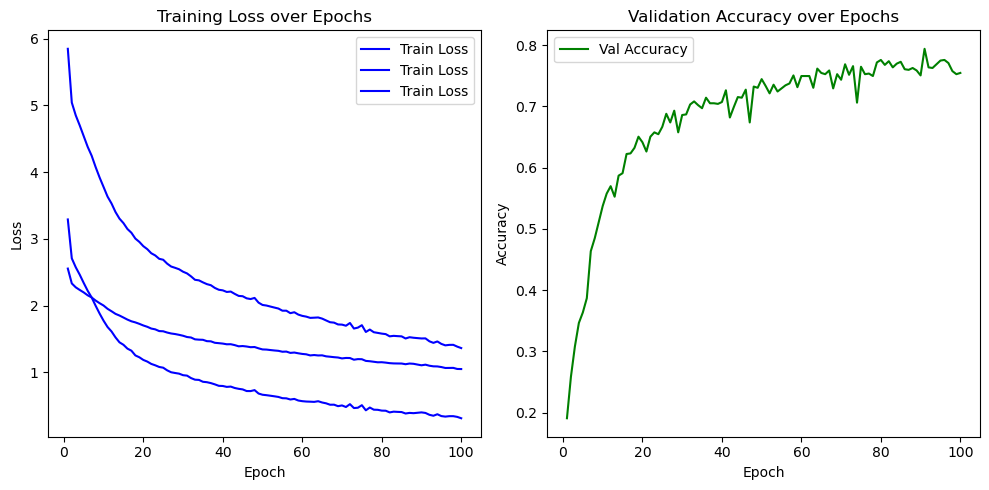

In [53]:
import matplotlib.pyplot as plt

epochs = range(1, 101)  # 100 epochs

plt.figure(figsize=(10, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Val Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


## MULTIMODAL

In [43]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.ReLU()
        )
    def forward(self, x):
        return self.net(x)

In [44]:
class MultiModalModel(nn.Module):
    def __init__(self, input_dims, num_diagnosis, num_stages, hidden_dim=64, embedding_dim=32):
        super(MultiModalModel, self).__init__()

        self.clinical_mlp = MLP(input_dims['clinical'], hidden_dim, embedding_dim)
        self.molecular_mlp = MLP(input_dims['molecular'], hidden_dim, embedding_dim)
        self.pathology_mlp = MLP(input_dims['pathology'], hidden_dim, embedding_dim)

        concat_dim = embedding_dim * 3

        self.stage_classifier = nn.Sequential(
            nn.Linear(concat_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_stages)
        )

        self.diagnosis_classifier = nn.Sequential(
            nn.Linear(concat_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_diagnosis)
        )

    def forward(self, clinical_x, molecular_x, pathology_x):
        clinical_embed = self.clinical_mlp(clinical_x)
        molecular_embed = self.molecular_mlp(molecular_x)
        pathology_embed = self.pathology_mlp(pathology_x)

        combined = torch.cat([clinical_embed, molecular_embed, pathology_embed], dim=1)
        diagnosis_out = self.diagnosis_classifier(combined)
        stage_out = self.stage_classifier(combined)

        return diagnosis_out, stage_out

In [45]:
from torch.utils.data import Dataset
import numpy as np
import torch

class MultiModalDataset(Dataset):
    def __init__(self, dataset_df, survival_days=730):
        self.samples = []
        
        for row in dataset_df.itertuples():
            stage = getattr(row, 'ajcc_pathologic_stage_ord')
            diagnosis = getattr(row, 'primary_diagnosis_ord')
            if stage is not None and diagnosis is not None:
                # Clinical Data Processing
                clinical_embedding = np.frombuffer(getattr(row, 'embedding_clin'), dtype=np.float32)
                clinical_embedding = clinical_embedding.reshape(getattr(row, 'embedding_shape_clin')).squeeze()
                
                # Molecular Data Processing
                molecular_embedding = getattr(row, 'embedding_mol').squeeze()
                
                # Pathology Data Processing
                pathology_embedding = np.frombuffer(getattr(row, 'embedding_path'), dtype=np.float32)
                pathology_embedding = pathology_embedding.reshape(getattr(row, 'embedding_shape_path')).squeeze()
                
                # Add the combined data and label to the sample list
                self.samples.append((clinical_embedding, molecular_embedding, pathology_embedding, diagnosis, stage))

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        clinical_embedding, molecular_embedding, pathology_embedding, diagnosis, stage = self.samples[idx]
        return (torch.tensor(clinical_embedding, dtype=torch.float32), 
                torch.tensor(molecular_embedding, dtype=torch.float32), 
                torch.tensor(pathology_embedding, dtype=torch.float32), 
                torch.tensor(diagnosis, dtype=torch.int32).type(torch.LongTensor),
                torch.tensor(stage, dtype=torch.int32).type(torch.LongTensor))


In [46]:
clinical_dataset = load_dataset("Lab-Rasool/TCGA", "clinical", split="gatortron")
pathology_report_dataset = load_dataset("Lab-Rasool/TCGA", "pathology_report", split="gatortron")
molecular_dataset = load_dataset("Lab-Rasool/TCGA", "molecular", split="senmo")

### Data Merging

In [ ]:
clinical_dataset

In [ ]:
for col in clinical_dataset.column_names:
    print(f'{col}: {clinical_dataset[col].count(None)}')

In [ ]:
# Examine how many times each patient ID shows up
clin_counts = defaultdict(int)
for id in clinical_dataset['case_submitter_id']:
    clin_counts[id] += 1
print(clin_counts)
print(f'There are {len(clin_counts)} PatientIDs')
print("Does each ID show up once?: ", all(count == 1 for count in list(clin_counts.values())))

# Print the ones that show multiple times
clin_anomalies = dict()
for id, count in clin_counts.items():
    if count != 1:
        clin_anomalies[id] = count
print(clin_anomalies)
print(f'{len(clin_anomalies)} PatientIDs were present > 1 times')

In [26]:
pathology_report_dataset

Dataset({
    features: ['id', 'data_format', 'access', 'file_name', 'md5sum', 'updated_datetime', 'data_type', 'data_category', 'state', 'type', 'file_size', 'created_datetime', 'PatientID', 'gdc_case_id', 'report_text', 'embedding', 'embedding_shape'],
    num_rows: 11208
})

In [ ]:
# Examine how many times each patient ID shows up
path_counts = defaultdict(int)
for id in pathology_report_dataset['PatientID']:
    path_counts[id] += 1
print(path_counts)
print(f'There are {len(path_counts)} PatientIDs')
print("Does each ID show up once?: ", all(count == 1 for count in list(path_counts.values())))

# Print the ones that show multiple times
path_anomalies = dict()
for id, count in path_counts.items():
    if count != 1:
        path_anomalies[id] = count
print(path_anomalies)
print(f'{len(path_anomalies)} PatientIDs were present > 1 times')

In [27]:
molecular_dataset

Dataset({
    features: ['PatientID', 'SampleID', 'Embeddings'],
    num_rows: 13804
})

In [ ]:
# Examine how many times each patient ID shows up
mol_counts = defaultdict(int)
for id in molecular_dataset['PatientID']:
    mol_counts[id] += 1
print(mol_counts)
print(f'There are {len(mol_counts)} PatientIDs')
print("Does each ID show up once?: ", all(count == 1 for count in list(mol_counts.values())))

# Print the ones that show multiple times
mol_anomalies = dict()
for id, count in mol_counts.items():
    if count != 1:
        mol_anomalies[id] = count
print(mol_anomalies)
print(f'{len(mol_anomalies)} PatientIDs were present > 1 times')

In [ ]:
# Clearly most of these only show up once, even if the sample letter makes it seem as if there may be more
sorted(molecular_dataset['SampleID'])

In [51]:
# Compute the final intersection of IDs to form our dataset. We want to exclude anomalies from each set and then
# find the intersection

clin_set = set(list(clin_counts.keys())) - set(list(clin_anomalies.keys()))
path_set = set(list(path_counts.keys())) - set(list(path_anomalies.keys()))
mol_set = set(list(mol_counts.keys())) - set(list(mol_anomalies.keys()))

final_ids = mol_set.intersection(path_set, clin_set)
print(len(final_ids))

8413


In [52]:
print(set(pathology_report_dataset.column_names).intersection(set(clinical_dataset.column_names)))
print(set(pathology_report_dataset.column_names).intersection(set(molecular_dataset.column_names)))
print(set(clinical_dataset.column_names).intersection(set(molecular_dataset.column_names)))

{'embedding', 'embedding_shape', 'state'}
{'PatientID'}
set()


In [53]:
# Now we want to remove all the ids not in final_ids from each of the datasets
# also rename colliding columns so things are clear after joining
clinical_filtered = clinical_dataset.filter(
    lambda x: x['case_submitter_id'] in final_ids
).rename_columns({'embedding': 'embedding_clin', 'embedding_shape': 'embedding_shape_clin', 'state': 'state_clin'}).to_pandas()
pathology_filtered = pathology_report_dataset.filter(
    lambda x: x['PatientID'] in final_ids
).rename_columns({'embedding': 'embedding_path', 'embedding_shape': 'embedding_shape_path', 'state': 'state_path'}).to_pandas()
molecular_filtered = molecular_dataset.filter(
    lambda x: x['PatientID'] in final_ids,
).rename_column('Embeddings', 'embedding_mol').to_pandas()

In [54]:
# Join on the PatientID
intermediate_merge = pathology_filtered.merge(clinical_filtered, how='inner', left_on='PatientID', right_on='case_submitter_id')
merged_dataset = intermediate_merge.merge(molecular_filtered, how='inner', on='PatientID')

In [55]:
# Give ordinal encodings to the label columns
merged_dataset = merged_dataset.dropna(subset=['primary_diagnosis', 'ajcc_pathologic_stage'])
merged_dataset['primary_diagnosis_ord'] = pd.factorize(merged_dataset['primary_diagnosis'])[0]
merged_dataset['ajcc_pathologic_stage_ord'] = pd.factorize(merged_dataset['ajcc_pathologic_stage'])[0]

In [44]:
len(merged_dataset)

4948

### Run Multitask Model

In [57]:
multidataset = MultiModalDataset(merged_dataset)

In [56]:
# 2. Get input dimensions
sample = multidataset[0]
print(sample[0].shape)
print(sample[1].shape)
print(sample[2].shape)
clinical_dim = sample[0].shape[0]
molecular_dim = sample[1].shape[0]
pathology_dim = sample[2].shape[0]

input_dims = {
    'clinical': clinical_dim,
    'molecular': molecular_dim,
    'pathology': pathology_dim
}

model = MultiModalModel(input_dims, int(np.max(merged_dataset['primary_diagnosis_ord'])) + 1, int(np.max(merged_dataset['ajcc_pathologic_stage_ord'])) + 1).to(device)  # or .to(device) if you're managing device explicitly

torch.Size([1024])
torch.Size([48])
torch.Size([1024])


In [58]:
# Split into train and val
train_size = int(0.8 * len(multidataset))
val_size = len(multidataset) - train_size
train_dataset_multi, val_dataset_multi = random_split(multidataset, [train_size, val_size])

train_loader_multi = DataLoader(train_dataset_multi, batch_size=64, shuffle=True)
val_loader_multi = DataLoader(val_dataset_multi, batch_size=64)

print(next(iter(train_loader_multi))[0].shape)
print(next(iter(train_loader_multi))[1].shape)
print(next(iter(train_loader_multi))[2].shape)
print(next(iter(train_loader_multi))[3].shape)

torch.Size([64, 1024])
torch.Size([64, 48])
torch.Size([64, 1024])
torch.Size([64])


In [59]:
criterion_diagnosis = nn.CrossEntropyLoss()
criterion_stage = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [60]:
merged_dataset['ajcc_pathologic_stage_ord'].min()

np.int64(0)

In [61]:
def train_multi(model, loader, optimizer, criterion_diagnosis, criterion_stage, device):
    model.train()
    total_loss, total_diag_loss, total_stage_loss = 0, 0, 0
    
    for batch in loader:
        clinical_x, molecular_x, pathology_x, diagnosis, stage = batch
        clinical_x = clinical_x.to(device)
        molecular_x = molecular_x.to(device)
        pathology_x = pathology_x.to(device)
        diagnosis = diagnosis.to(device)
        stage = stage.to(device)

        optimizer.zero_grad()
        diagnosis_output, stage_output = model(clinical_x, molecular_x, pathology_x)

        loss_diag = criterion_diagnosis(diagnosis_output, diagnosis)
        loss_stage = criterion_stage(stage_output, stage)
        loss = loss_diag + loss_stage

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_diag_loss += loss_diag.item()
        total_stage_loss += loss_stage.item()

    return total_loss / len(loader), total_diag_loss / len(loader), total_stage_loss / len(loader)


def evaluate_multi(model, loader, criterion_diagnosis, criterion_stage, device):
    model.eval()
    total_loss, total_diag_loss, total_stage_loss = 0, 0, 0
    total_correct_diag = 0
    total_correct_stage = 0
    total_diag = 0
    total_stage = 0

    with torch.no_grad():
        for batch in loader:
            clinical_x, molecular_x, pathology_x, diagnosis, stage = batch
            clinical_x = clinical_x.to(device)
            molecular_x = molecular_x.to(device)
            pathology_x = pathology_x.to(device)
            diagnosis = diagnosis.to(device)
            stage = stage.to(device)

            diagnosis_output, stage_output = model(clinical_x, molecular_x, pathology_x)

            loss_diag = criterion_diagnosis(diagnosis_output, diagnosis)
            loss_stage = criterion_stage(stage_output, stage)
            loss = loss_diag + loss_stage

            total_loss += loss.item()
            total_diag_loss += loss_diag.item()
            total_stage_loss += loss_stage.item()

            # Compute accuracy for diagnosis
            _, predicted_diag = torch.max(diagnosis_output, 1)
            total_correct_diag += (predicted_diag == diagnosis).sum().item()
            total_diag += diagnosis.size(0)

            # Stage accuracy
            _, predicted_stage = torch.max(stage_output, 1)
            total_correct_stage += (predicted_stage == stage).sum().item()
            total_stage += stage.size(0)

    diagnosis_accuracy = total_correct_diag / total_diag
    stage_accuracy = total_correct_stage / total_stage
    return (total_loss / len(loader),
            total_diag_loss / len(loader),
            total_stage_loss / len(loader),
            diagnosis_accuracy, stage_accuracy)


In [62]:
train_losses = []
val_losses = []
val_accuracies = []
num_epochs = 100
for epoch in range(num_epochs):
    train_loss, train_diag_loss, train_stage_loss = train_multi(
        model, train_loader_multi, optimizer,
        criterion_diagnosis, criterion_stage, device
    )
    
    val_loss, val_diag_loss, val_stage_loss, val_diag_acc, val_stage_acc = evaluate_multi(
        model, val_loader_multi,
        criterion_diagnosis, criterion_stage, device
    )


    train_losses.append((train_loss, train_diag_loss, train_stage_loss))
    val_losses.append((val_loss, val_diag_loss, val_stage_loss))
    val_accuracies.append((val_diag_acc, val_stage_acc))

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f} | Train Diagnosis Loss: {train_diag_loss:.4f} | Train Stage Loss: {train_stage_loss:.4f} || "
          f"Val Loss: {val_loss:.4f} | Val Diagnosis Acc: {val_diag_acc:.4f} | | Val Stage Acc: {val_stage_acc:.4f} | Val Diagnosis Loss: {val_diag_loss:.4f} | Val Stage Loss: {val_stage_loss:.4f}")


Epoch 1/100 - Train Loss: 5.7623 | Train Diagnosis Loss: 3.2636 | Train Stage Loss: 2.4988 || Val Loss: 5.0951 | Val Diagnosis Acc: 0.2232 | | Val Stage Acc: 0.2030 | Val Diagnosis Loss: 2.7610 | Val Stage Loss: 2.3341
Epoch 2/100 - Train Loss: 5.0617 | Train Diagnosis Loss: 2.7483 | Train Stage Loss: 2.3133 || Val Loss: 4.9224 | Val Diagnosis Acc: 0.2505 | | Val Stage Acc: 0.2253 | Val Diagnosis Loss: 2.6026 | Val Stage Loss: 2.3198
Epoch 3/100 - Train Loss: 4.8525 | Train Diagnosis Loss: 2.5807 | Train Stage Loss: 2.2718 || Val Loss: 4.7096 | Val Diagnosis Acc: 0.3273 | | Val Stage Acc: 0.2677 | Val Diagnosis Loss: 2.4613 | Val Stage Loss: 2.2482
Epoch 4/100 - Train Loss: 4.6631 | Train Diagnosis Loss: 2.4342 | Train Stage Loss: 2.2290 || Val Loss: 4.6028 | Val Diagnosis Acc: 0.3707 | | Val Stage Acc: 0.2566 | Val Diagnosis Loss: 2.3583 | Val Stage Loss: 2.2445
Epoch 5/100 - Train Loss: 4.4972 | Train Diagnosis Loss: 2.3066 | Train Stage Loss: 2.1905 || Val Loss: 4.4914 | Val Diagnos

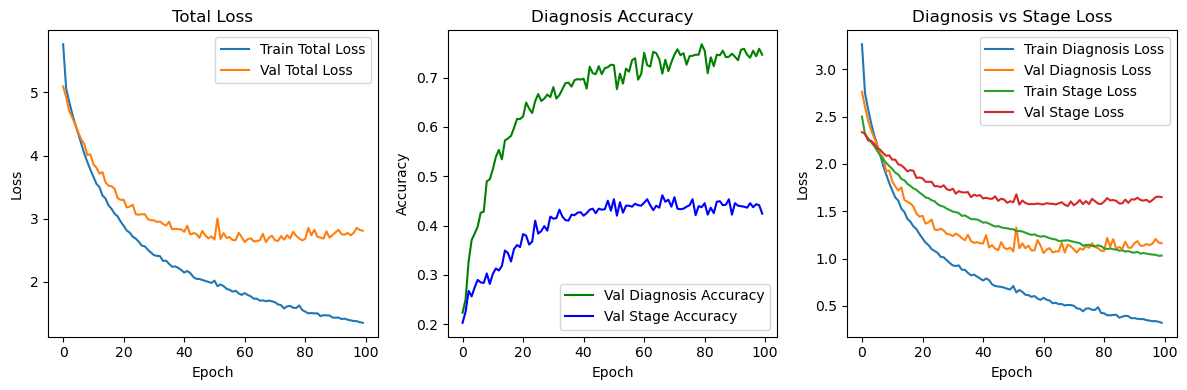

In [65]:
import matplotlib.pyplot as plt
# Plot total training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot([loss for loss, _, _ in train_losses], label='Train Total Loss')
plt.plot([loss for loss, _, _ in val_losses], label='Val Total Loss')
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot diagnosis accuracy
plt.subplot(1, 3, 2)
plt.plot([acc for acc, _ in val_accuracies], label='Val Diagnosis Accuracy', color='green')
plt.title('Diagnosis Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Stage accuracy
plt.subplot(1, 3, 2)
plt.plot([acc for _ , acc in val_accuracies], label='Val Stage Accuracy', color='blue')
plt.title('Diagnosis Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 3, 3)
plt.plot([loss for _, loss, _ in train_losses], label='Train Diagnosis Loss')
plt.plot([loss for _, loss, _ in val_losses], label='Val Diagnosis Loss')
plt.plot([loss for _, _, loss in train_losses], label='Train Stage Loss')
plt.plot([loss for _, _, loss in val_losses], label='Val Stage Loss')
plt.title('Diagnosis vs Stage Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [66]:
# def train_multi(model, loader):
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss, total_diag_loss, total_stage_loss = 0, 0, 0
    
    for batch in train_loader_multi:
        # batch = np.array(batch)
        # print(batch.shape)
        clinical_x, molecular_x, pathology_x, diagnosis, stage = batch
        # print(clinical_x)
        # print(molecular_x)
        # print(pathology_x)
        # print(diagnosis)
        # print(stage)
        clinical_x = clinical_x.to(device)
        molecular_x = molecular_x.to(device)
        pathology_x = pathology_x.to(device)
        diagnosis = diagnosis.to(device)
        stage = stage.to(device)


        optimizer.zero_grad()
        diagnosis_output, stage_output = model(clinical_x, molecular_x, pathology_x)
        
        # print(diagnosis_output.shape)
        # print(diagnosis_output)
        # print(diagnosis.shape)
        # print(diagnosis.dtype)
        loss_diag = criterion_diagnosis(diagnosis_output, diagnosis)
        loss_stage = criterion_stage(stage_output, stage)
        loss = loss_diag + loss_stage

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_diag_loss += loss_diag.item()
        total_stage_loss += loss_stage.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Total Loss: {total_loss:.4f} | Diagnosis Loss: {total_diag_loss:.4f} | Stage Loss: {total_stage_loss:.4f}")




Epoch 1/100 - Total Loss: 83.1835 | Diagnosis Loss: 20.0134 | Stage Loss: 63.1701
Epoch 2/100 - Total Loss: 82.4149 | Diagnosis Loss: 19.8806 | Stage Loss: 62.5343
Epoch 3/100 - Total Loss: 84.0245 | Diagnosis Loss: 20.3019 | Stage Loss: 63.7226
Epoch 4/100 - Total Loss: 86.2690 | Diagnosis Loss: 22.9969 | Stage Loss: 63.2720
Epoch 5/100 - Total Loss: 80.4513 | Diagnosis Loss: 18.3150 | Stage Loss: 62.1362


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
    model.eval()
    total_loss, total_diag_loss, total_stage_loss = 0, 0, 0

    for batch in val_loader_multi:
        # batch = np.array(batch)
        # print(batch.shape)
        clinical_x, molecular_x, pathology_x, diagnosis, stage = batch
        # print(clinical_x)
        # print(molecular_x)
        # print(pathology_x)
        # print(diagnosis)
        # print(stage)
        clinical_x = clinical_x.to(device)
        molecular_x = molecular_x.to(device)
        pathology_x = pathology_x.to(device)
        diagnosis = diagnosis.to(device)
        stage = stage.to(device)


        diagnosis_output, stage_output = model(clinical_x, molecular_x, pathology_x)
        
        # print(diagnosis_output.shape)
        # print(diagnosis_output)
        # print(diagnosis.shape)
        # print(diagnosis.dtype)
        loss_diag = criterion_diagnosis(diagnosis_output, diagnosis)
        loss_stage = criterion_stage(stage_output, stage)
        loss = loss_diag + loss_stage

        total_loss += loss.item()
        total_diag_loss += loss_diag.item()
        total_stage_loss += loss_stage.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Total Loss: {total_loss:.4f} | Diagnosis Loss: {total_diag_loss:.4f} | Stage Loss: {total_stage_loss:.4f}")